## miniProject4
#### importing data

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge -c plotly jupyter-dash


Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [51]:
import pandas as pd
import os
import statistics
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.tsa.holtwinters as ets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go


In [4]:
CancerData = pd.read_csv('Cancer Incidence 2000-2017.txt', sep ='\t')
CancerData = CancerData.drop('Notes',1)
CancerData = CancerData.drop('Leading Cancer Sites Code',1)
CancerData = CancerData.drop('Year Code',1)
CancerData = CancerData.drop('States Code',1)

#splitting into individual states
StatesList = list()
StateOrder = list()
for StateDF in CancerData.groupby('States'):
    StateOrder.append(StateDF[0])
    test = pd.DataFrame(StateDF[1])    
    StatesList.append(test)

### descriptive analytics

In [5]:
#developing only for state of Utah. Predicting different cancers in UT
UtahDF = StatesList[44]
YearList = pd.unique(UtahDF['Year'].to_list()).tolist()
CancerList = pd.unique(UtahDF['Leading Cancer Sites'].to_list()).tolist()

UtahDF['Count'] = pd.to_numeric(UtahDF['Count'], downcast="float")
UtahDF.columns = UtahDF.columns.str.replace(' ', '_')

#Rates are for 100,000

#### by Year

In [6]:
YearMean = list()
YearSTD = list()
YearMedian = list()
YearlyCancerCounts = list()
for Year in YearList:
    YearDF = UtahDF.query("Year=="+str(Year))
    YearlyCancerCounts.append(YearDF['Count'].tolist())
    YearMean.append(YearDF["Count"].mean())
    YearMedian.append(YearDF["Count"].median())
    YearSTD.append(YearDF["Count"].std())


#### by Cancer

In [7]:
CancerMean = list()
CancerSTD = list()
CancerMedian = list()

CountList = UtahDF['Count'].tolist()
for x in range(0, len(CancerList)):
    Listsub = CountList[18*x:18*(x+1)]
    CancerMean.append(statistics.mean(Listsub))
    CancerSTD.append(statistics.stdev(Listsub))
    CancerMedian.append(statistics.median(Listsub))

#### graphing numerical data

<Figure size 432x288 with 0 Axes>

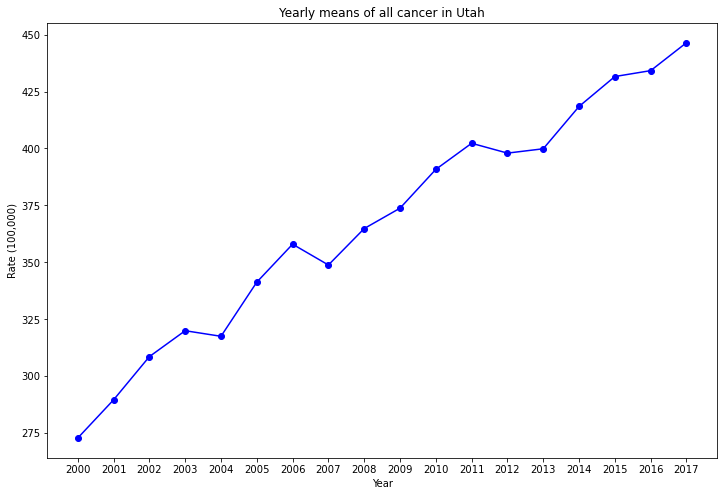

In [8]:
plt.figure(1)
plt.figure(figsize = (12,8))
#replace YearMean with desired Yearly data (Median/Standard Deviation)
plt.plot(YearList, YearMean, marker = 'o',color = 'blue')
plt.xticks(YearList)
plt.xlabel('Year')
plt.ylabel('Rate (100,000)')
plt.title('Yearly means of all cancer in Utah')
plt.show()

<Figure size 432x288 with 0 Axes>

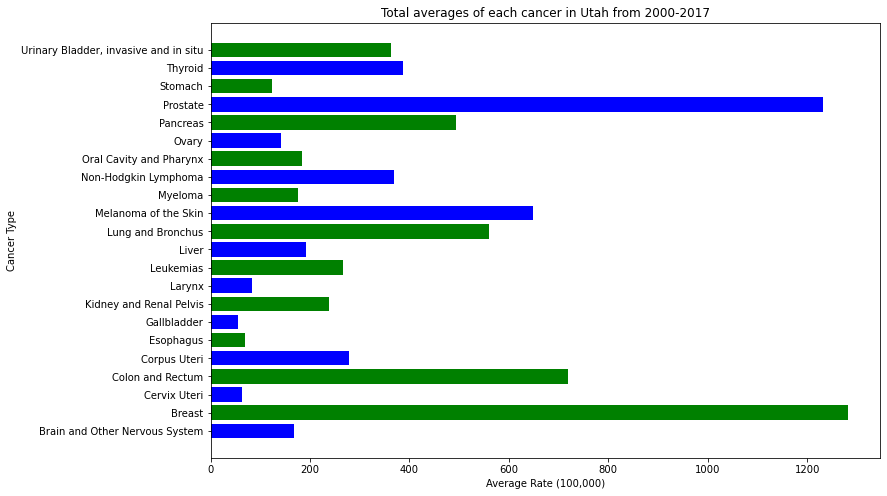

In [9]:
plt.figure(2)
plt.figure(figsize = (12,8))
plt.barh(CancerList, CancerMean, tick_label = CancerList, color = ['blue', 'green'])
plt.ylabel('Cancer Type')
plt.xlabel('Average Rate (100,000)')
plt.title('Total averages of each cancer in Utah from 2000-2017')
plt.show()

#### Yearly Cancer split

<Figure size 432x288 with 0 Axes>

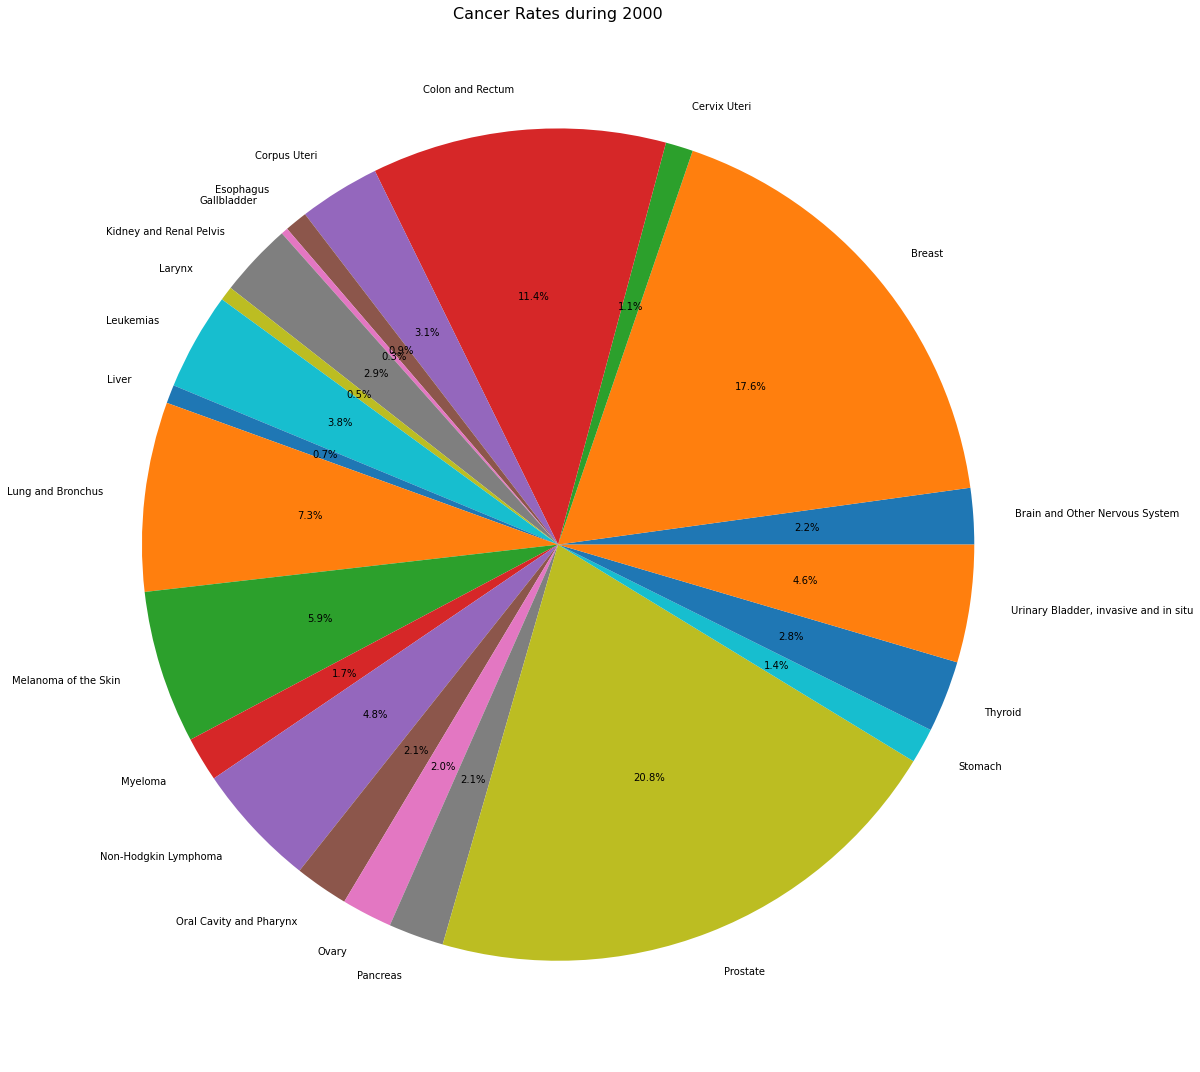

In [10]:
#simple 2000

chosenYear = 0 #pick through 0-17 (2000-2017)
Total = sum(YearlyCancerCounts[chosenYear])
YearlyPercents = list()
for x in YearlyCancerCounts[chosenYear]:
    YearlyPercents.append(x/Total * 100)

plt.figure(3)
plt.figure(figsize = (20,15))

plt.pie(YearlyCancerCounts[chosenYear], labels = CancerList, autopct='%1.1f%%')
plt.title('Cancer Rates during ' + str(chosenYear+2000), fontsize = 16)
#plt.legend(CancerList,fontsize = 8)
plt.tight_layout()
plt.show()


#### Making Model

In [27]:
selection = 0 #selection can only be 0-17
ModelList = CountList[18*selection:18*(selection+1)] #building model for brain
Modeldata = {'Year': YearList,
          'Rate': ModelList}
ModelDF = pd.DataFrame(Modeldata, columns = ['Year', 'Rate'])

C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation



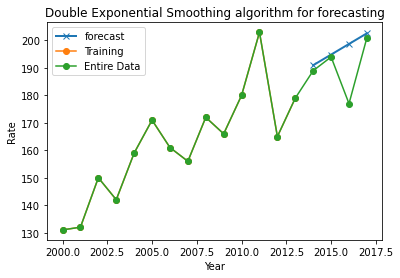

In [85]:
z = 14
Training = ModelList[:z] #2015-2017 will be for testing
YearTestingList = YearList[z:]
des = ets.ExponentialSmoothing(Training,trend = 'additive', seasonal = None).fit()
forecast = des.forecast(steps = (18-z))
testest= forecast.tolist()
forecastDF = pd.DataFrame(zip(YearTestingList,testest), columns = ['Year', 'Rate'])

plt.plot(YearTestingList,forecast, label = 'forecast', marker = 'x', linewidth = 2.0)
plt.plot(YearList[:z],Training, label = 'Training', marker = 'o')
plt.plot(YearList, ModelList, label = 'Entire Data', marker = 'o')

plt.legend(loc = 'upper left')
plt.title('Double Exponential Smoothing algorithm for forecasting')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.show()


#### metrics

In [13]:
TestingValues = ModelList[z:]
MAE = mean_absolute_error(TestingValues,forecast)
MSE = mean_squared_error(TestingValues,forecast)
# normalised_mean_squared_error
NMSE = MSE / (np.sum((TestingValues - np.mean(TestingValues)) ** 2)/(len(TestingValues)-1))

print('Mean Absolute Error:', round(MAE, 3))
print('Mean Squared Error:', round(MSE, 3))
print('Normalized Mean Squared Error:', round(NMSE, 3))


Mean Absolute Error: 6.551
Mean Squared Error: 119.966
Normalized Mean Squared Error: 1.173


#### Application

In [87]:
df = px.data.tips()

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Cancer Predictive Algorithm"),
    dcc.Graph(id='graph'),
    html.Label([
        "Cancer",
        dcc.Dropdown(
            id='Cancer List dropdown', clearable=False,
            value='Brain and Other Nervous System', options=[
                {'label': c, 'value': c}
                for c in CancerList
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("Cancer List dropdown", "value")]
)
def update_figure(Cancer):
    fig = go.Figure([
        go.Scatter(
        name='Complete data',
        x=ModelDF['Year'],
        y=ModelDF['Rate'],
        mode='markers+lines',
        marker=dict(color='blue', size=5),
        showlegend=True
    ),
        go.Scatter(
        name='Modeling',
        x=forecastDF['Year'],
        y=forecastDF['Rate'],
        mode='markers+lines',
        marker=dict(color='red', size=5),
        showlegend=True
        )
    ])
    fig.update_layout(
    yaxis_title='Rate (per 100,000)',
    title='Cancer Prediction Algorithm',
    hovermode="x"
)

    return fig
# Run app and display result inline in the notebook
app.run_server(mode='inline')